# **Introduction**

Given the fact that most low-eviction neighborhoods exist in Staten Island and Queens, we have to ask if the building types play a role in influencing the likelihoods of evictions. If apartments are more prone to evictions, it means policy makers need to direct more attention to target apartment building intensive areas and have policies targeting at those neighborhoods.

The questions we asked and answered in this notebook include:

1. What percentage of evictions in a borough (Manhattan/Brooklyn) occur in apartments vs. houses?
2. Are apartments more likely to be evicted than houses in a given borough?
3. If so, are the odss the same? How do boroughs compare in eviction patterns?
4. Is the difference in eviction rates between apartments and houses statistically significant?


In [ ]:
brooklyn_evi_apt_rate = bk_evi_apt_count / bk_apt_count * 100
brooklyn_evi_house_rate = bk_evi_house_count / bk_house_count * 100
compare = pd.DataFrame({
    'man': [man_apt_evi_rate, man_house_evi_rate],
    'bk': [bk_apt_evi_rate, bk_house_evi_rate]
}, index=['apt', 'house'])

# this is basically a slice of the comprehensive dataframe we had towards the end, but this directly answers question 2.
# the odds are answered through the eviction rates throughout this notebook
# question 4 was answered through stratified chi-square test

,man,bk
apt,8.645172,3.729612
house,0.058824,0.325344


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as pltsa
import os
import io
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.stats.contingency_tables import StratifiedTable
from scipy.stats import chi2_contingency
# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
# display all columns
# avoid scientific digit
# pd.options.display.float_format = '{:.2f}'.format

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# link1 = 'bbl_evictions_311_svi_covid_times_svi.csv'
# link2 = 'bbl_evictions_311_svi_covid_svi.csv'
link1 = '/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_svi.csv'
link2 = '/content/drive/My Drive/X999/bbl_evictions_311_svi_covid_svi.csv'
normal = pd.read_csv(link1)
covid = pd.read_csv(link2)

In [20]:
covid.columns, covid.columns, covid.shape, covid.shape

(Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'zipcode', 'ejectment',
        ...
        'children_impacted_nta_per_1kpop', 'poverty_impacted_nta_per_1kpop',
        'disability_impacted_nta_per_1kpop',
        'unemployed_impacted_nta_per_1kpop', 'elderly_impacted_nta_per_1kpop',
        'bh_impacted_nta_per_1kpop', 'hburd_impacted_nta_per_1kpop',
        'average_year_eviction_per_building_nta(nta)',
        'average_3year_eviction_count_per_unit(building)', 'bh_pct'],
       dtype='object', length=107),
 Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'zipcode', 'ejectment',
        ...
        'children_impacted_nta_per_1kpop', 'poverty_impacted_nta_per_1kpop',
        'disability_impacted_nta_per_1kpop',
        'unemployed_impacted_nta_per_1kpop', 'elder

# **Step1: Building Data**

In [5]:
link3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
building = pd.read_csv(link3)

In [6]:
building.borough.unique()

array(['BK', 'QN', 'SI', 'MN', 'BX'], dtype=object)

In [7]:
building.building_category.unique(), building.building_type.unique()

(array(['single-family', 'primarily_res_with_mixed_use', 'walk-up',
        'two-family', 'condo-co-op', 'elevator'], dtype=object),
 array(['post-war', 'pre-war'], dtype=object))

In [8]:
man_bbl = building[building['borough'] == 'MN']
man_bbl.shape

(29264, 97)

In [9]:
bk_bbl = building[building['borough'] == 'BK']
bk_bbl.shape

(244611, 97)

In [10]:
bx_bbl = building[building['borough'] == 'BX']
bx_bbl.shape

(74875, 97)

In [11]:
quees_bbl = building[building['borough'] == 'QN']
quees_bbl.shape

(293494, 97)

In [12]:
si_bbl = building[building['borough'] == 'SI']
si_bbl.shape

(110375, 97)

In [13]:
man_house_bbl = man_bbl[man_bbl['building_category'].isin(['two-family', 'single-family'])]
man_apt_bbl = man_bbl[~man_bbl['building_category'].isin(['two-family', 'single-family'])]
man_house_count = man_house_bbl.shape[0]
man_apt_count = man_apt_bbl.shape[0]
man_house_bbl.shape, man_apt_bbl.shape, man_house_count, man_apt_count

((4080, 97), (25184, 97), 4080, 25184)

In [14]:
bk_house_bbl = bk_bbl[bk_bbl['building_category'].isin(['two-family', 'single-family'])]
bk_apt_bbl = bk_bbl[~bk_bbl['building_category'].isin(['two-family', 'single-family'])]
bk_house_count = bk_house_bbl.shape[0]
bk_apt_count = bk_apt_bbl.shape[0]
bk_house_bbl.shape, bk_apt_bbl.shape, bk_house_count, bk_apt_count

((155835, 97), (88776, 97), 155835, 88776)

In [15]:
bx_house_bbl = bx_bbl[bx_bbl['building_category'].isin(['two-family', 'single-family'])]
bx_apt_bbl = bx_bbl[~bx_bbl['building_category'].isin(['two-family', 'single-family'])]
bx_house_count = bx_house_bbl.shape[0]
bx_apt_count = bx_apt_bbl.shape[0]
bx_house_bbl.shape, bx_apt_bbl.shape, bx_house_count, bx_apt_count

((51422, 97), (23453, 97), 51422, 23453)

In [16]:
queen_house_bbl = quees_bbl[quees_bbl['building_category'].isin(['two-family', 'single-family'])]
queen_apt_bbl = quees_bbl[~quees_bbl['building_category'].isin(['two-family', 'single-family'])]
queen_house_count = queen_house_bbl.shape[0]
queen_apt_count = queen_apt_bbl.shape[0]
queen_house_bbl.shape, queen_apt_bbl.shape, queen_house_count, queen_apt_count

((246304, 97), (47190, 97), 246304, 47190)

In [17]:
si_house_bbl = si_bbl[si_bbl['building_category'].isin(['two-family', 'single-family'])]
si_apt_bbl = si_bbl[~si_bbl['building_category'].isin(['two-family', 'single-family'])]
si_house_count = si_house_bbl.shape[0]
si_apt_count = si_apt_bbl.shape[0]
si_house_bbl.shape, si_apt_bbl.shape, si_house_count, si_apt_count

((107256, 97), (3119, 97), 107256, 3119)

# **Step 2: Covid-Evictions**

In [21]:
covid.building_category.unique()

array(['walk-up', 'elevator', 'two-family', 'condo-co-op',
       'single-family', 'primarily_res_with_mixed_use'], dtype=object)

### **Note: the first two rates should add up to 100, but the last two do not have to. The first two resulted rates mean out of all the evictions (per borough), how many percentages of them happened in houses or apartments, respectively. The second pair of rates answer the question: out of all the apartments/house, how many percentages of them had evictions per borough per year**

## **2.1 Manhattan**

In [22]:
manhattan_evi = covid[covid['borough'] == 'MANHATTAN']
manhattan_evi.shape

(893, 107)

In [23]:
manhattan_evi_count = manhattan_evi.shape[0]/5
manhattan_evi_count
# on average, how many evictions per year does manhattan have

178.6

In [24]:
man_evi_house = manhattan_evi[manhattan_evi['building_category'].isin(['two-family', 'single-family'])]
man_evi_apt= manhattan_evi[~manhattan_evi['building_category'].isin(['two-family', 'single-family'])]
man_evi_house_count = man_evi_house.shape[0]/5
man_evi_apt_count = man_evi_apt.shape[0]/5
man_evi_house.shape, man_evi_apt.shape, man_evi_house_count, man_evi_apt_count

((2, 107), (891, 107), 0.4, 178.2)

In [25]:
man_apt_count/man_bbl.shape[0], man_house_count/man_bbl.shape[0], man_bbl.shape[0],

(0.8605795516675779, 0.1394204483324221, 29264)

In [26]:
man_evi_house_rate = man_evi_house_count/manhattan_evi_count*100
man_evi_apt_rate = man_evi_apt_count/manhattan_evi_count*100
man_house_evi_rate = man_evi_house_count/man_house_count*100
man_apt_evi_rate = man_evi_apt_count / man_apt_count*100
man_evi_house_rate, man_evi_apt_rate, man_house_evi_rate, man_apt_evi_rate,  0.08645171537484116/0.000588235294117647

(0.22396416573348266,
 99.77603583426652,
 0.009803921568627453,
 0.7075921219822109,
 146.96791613723)

### **0.1% of evictions in manhattan happened in houses. 99% of evictions in manhattan happened in apartments. 0.05% of manhattan houses had evcitions. 8.645 of manhattan apts had evictions. This suggests if you live in apartments, you are ~147X more likely to be evicted than living in houses in Manhattan.**

## **2.2 Brooklyn**

In [27]:
brooklyn_evi = covid[covid['borough'] == 'BROOKLYN']
brooklyn_evi.shape

(1882, 107)

In [28]:
brooklyn_evi_count = brooklyn_evi.shape[0]/5
brooklyn_evi_count

376.4

In [29]:
bk_evi_house = brooklyn_evi[brooklyn_evi['building_category'].isin(['two-family', 'single-family'])]
bk_evi_apt = brooklyn_evi[~brooklyn_evi['building_category'].isin(['two-family', 'single-family'])]
bk_evi_house_count = bk_evi_house.shape[0]/5
bk_evi_apt_count = bk_evi_apt.shape[0]/5
bk_evi_house.shape, bk_evi_apt.shape, bk_evi_house_count, bk_evi_apt_count

((259, 107), (1623, 107), 51.8, 324.6)

In [30]:
bk_evi_house_rate = bk_evi_house_count/brooklyn_evi_count*100
bk_evi_apt_rate = bk_evi_apt_count/brooklyn_evi_count*100
bk_house_evi_rate = bk_evi_house_count/bk_house_count*100
bk_apt_evi_rate = bk_evi_apt_count / bk_apt_count*100
bk_evi_house_rate, bk_evi_apt_rate, bk_house_evi_rate, bk_apt_evi_rate, bk_apt_evi_rate/bk_house_evi_rate

(13.761955366631243,
 86.23804463336877,
 0.03324028620014759,
 0.36563936198972696,
 10.999886095689018)

### **these stats suggest about 13.27 % of the evictions in BK happened in houses. About 86.72% of the evictions in BK happened in apartments. About 0.325% of bk houses experienced evictions. About 3.729% of bk apartments experinced evictions. These are all per year on average stats. This suggests that if you live in apartments, you are 11.46 times more likely to get evicted than living in apartments.**

## **2.3 Queens**

In [31]:
queens_evi = covid[covid['borough'] == 'QUEENS']
queens_evi.shape

(683, 107)

In [32]:
queens_evi_count = queens_evi.shape[0]/5
queens_evi_count

136.6

In [33]:
queens_evi_house = queens_evi[queens_evi['building_category'].isin(['two-family', 'single-family'])]
queens_evi_apt = queens_evi[~queens_evi['building_category'].isin(['two-family', 'single-family'])]
queens_evi_house_count = queens_evi_house.shape[0]/5
queens_evi_apt_count = queens_evi_apt.shape[0]/5
queens_evi_house.shape, queens_evi_apt.shape, queens_evi_house_count, queens_evi_apt_count

((215, 107), (468, 107), 43.0, 93.6)

In [34]:
queens_evi_house_rate = queens_evi_house_count/queens_evi_count*100
queens_evi_apt_rate = queens_evi_apt_count/queens_evi_count*100
queens_house_evi_rate = queens_evi_house_count/queen_house_count*100
queens_apt_evi_rate = queens_evi_apt_count / queen_apt_count*100
queens_evi_house_rate, queens_evi_apt_rate, queens_house_evi_rate, queens_apt_evi_rate, queens_apt_evi_rate/queens_house_evi_rate

(31.4787701317716,
 68.5212298682284,
 0.017458100558659217,
 0.19834710743801653,
 11.361322314049588)

### **about 27.08% of the evictions happened in queens happened in houses. About 72.91% of the evictions happened in queens happened in aparts. About 0.2% of houses in queens had evictions per year. About 14.05% of apartments in queens had evictions per year.**

## **2.4 Staten Island**

In [35]:
si_evi = covid[covid['borough'] == 'STATEN ISLAND']
si_evi.shape

(238, 107)

In [36]:
si_evi_count = si_evi.shape[0]/5
si_evi_count

47.6

In [37]:
si_evi_house = si_evi[si_evi['building_category'].isin(['two-family', 'single-family'])]
si_evi_apt = si_evi[~si_evi['building_category'].isin(['two-family', 'single-family'])]
si_evi_house_count = si_evi_house.shape[0]/5
si_evi_apt_count = si_evi_apt.shape[0]/5
si_evi_house.shape, si_evi_apt.shape, si_evi_house_count, si_evi_apt_count

((110, 107), (128, 107), 22.0, 25.6)

In [38]:
si_evi_house_rate = si_evi_house_count/si_evi_count*100
si_evi_apt_rate = si_evi_apt_count/si_evi_count*100
si_house_evi_rate = si_evi_house_count/si_house_count*100
si_apt_evi_rate = si_evi_apt_count / si_apt_count*100
si_evi_house_rate, si_evi_apt_rate, si_house_evi_rate, si_apt_evi_rate, si_apt_evi_rate/si_house_evi_rate
# the first two should add up to 1, but the last two do not have to

(46.21848739495798,
 53.78151260504202,
 0.020511673006638323,
 0.8207758897082399,
 40.0150631029759)

### **about 41.29% of the evictions happened in si happened in houses. About 58.71% of the evictions happened in si happened in aparts. About 0.015% of houses in si had evictions per year. About 48.90% of apartments in si had evictions per year.**

## **2.5 Bronx**

In [39]:
bx_evi = covid[covid['borough'] == 'BRONX']
bx_evi.shape

(1690, 107)

In [40]:
bx_evi_count = bx_evi.shape[0]/5
bx_evi_count

338.0

In [41]:
bx_evi_house = bx_evi[bx_evi['building_category'].isin(['two-family', 'bxngle-family'])]
bx_evi_apt = bx_evi[~bx_evi['building_category'].isin(['two-family', 'bxngle-family'])]
bx_evi_house_count = bx_evi_house.shape[0]/5
bx_evi_apt_count = bx_evi_apt.shape[0]/5
bx_evi_house.shape, bx_evi_apt.shape, bx_evi_house_count, bx_evi_apt_count

((130, 107), (1560, 107), 26.0, 312.0)

In [42]:
bx_evi_house_rate = bx_evi_house_count/bx_evi_count*100
bx_evi_apt_rate = bx_evi_apt_count/bx_evi_count*100
bx_house_evi_rate = bx_evi_house_count/bx_house_count*100
bx_apt_evi_rate = bx_evi_apt_count / bx_apt_count*100
bx_evi_house_rate, bx_evi_apt_rate, bx_house_evi_rate, bx_apt_evi_rate, bx_apt_evi_rate/bx_house_evi_rate

(7.6923076923076925,
 92.3076923076923,
 0.050562016257632916,
 1.3303202148978808,
 26.310663880953395)

### **about 5.10% of the evictions happened in bx happened in houses. About 94.90% of the evictions happened in bx happened in aparts. About 0.200% of houses in bx had evictions per year. About 40.82% of apartments in bx had evictions per year.**

Let's put together some neat dataframes for comparisons and potentially for excel and arcgis.

# **Step 3: createing dataframes for bette readability**

## **3.1 A simple summary df (for excel) chart**

In [43]:
all_borough_data = {'borough': ['manhattan', 'brooklyn', 'queens', 'staten island', 'bronx'],
        'evictions_happened_in_house_rates': [man_evi_house_rate, bk_evi_house_rate, queens_evi_house_rate, si_evi_house_rate, bx_evi_house_rate],
        'eviction_happened_in_apt_rates': [man_evi_apt_rate, bk_evi_apt_rate, queens_evi_apt_rate, si_evi_apt_rate, bx_evi_apt_rate],
        'house_that_had_eviction_rates': [man_house_evi_rate, bk_house_evi_rate, queens_house_evi_rate, si_house_evi_rate, bx_house_evi_rate],
        'apt_that_had_eviction_rates': [man_apt_evi_rate, bk_apt_evi_rate, queens_apt_evi_rate, si_apt_evi_rate, bx_apt_evi_rate]}

summary_df  = pd.DataFrame(all_borough_data)
summary_df
# this can be used in one or two excel chart

,borough,evictions_happened_in_house_rates,eviction_happened_in_apt_rates,house_that_had_eviction_rates,apt_that_had_eviction_rates
0,manhattan,0.223964,99.776036,0.009804,0.707592
1,brooklyn,13.761955,86.238045,0.033240,0.365639
2,queens,31.478770,68.521230,0.017458,0.198347
3,staten island,46.218487,53.781513,0.020512,0.820776
4,bronx,7.692308,92.307692,0.050562,1.330320


## **3.2 Simple building and eviction count/boros (pie) chart (for excel)**

In [44]:
borough_evi_building_total = {
    'borough': ['manhattan', 'brooklyn', 'queens', 'staten island', 'bronx'],
    'evictions_total_per_year': [manhattan_evi_count, brooklyn_evi_count, queens_evi_count, si_evi_count, bx_evi_count],
    'building_total': [man_bbl.shape[0], bk_bbl.shape[0], quees_bbl.shape[0], si_bbl.shape[0], bx_bbl.shape[0]],
    'evictions_out_of_all_building_boro_pct': [manhattan_evi_count/man_bbl.shape[0]*100, brooklyn_evi_count/bk_bbl.shape[0]*100, queens_evi_count/quees_bbl.shape[0]*100, si_evi_count/si_bbl.shape[0]*100, bx_evi_count/bx_bbl.shape[0]*100]
}

borough_evi_total_df = pd.DataFrame(borough_evi_building_total)
borough_evi_total_df
# another candidate for excel pie chart

,borough,evictions_total_per_year,building_total,evictions_out_of_all_building_boro_pct
0,manhattan,178.6,29264,0.610306
1,brooklyn,376.4,244611,0.153877
2,queens,136.6,293494,0.046543
3,staten island,47.6,110375,0.043126
4,bronx,338.0,74875,0.451419


In [45]:
all_apt = man_apt_count + bk_apt_count + queen_apt_count + si_apt_count + bx_apt_count
all_house = man_house_count + bk_house_count + queen_house_count + si_house_count + bx_house_count
all_apt_evi = man_evi_apt_count + bk_evi_apt_count + queens_evi_apt_count + si_evi_apt_count + bx_evi_apt_count
all_house_evi = man_evi_house_count + bk_evi_house_count + queens_evi_house_count + si_evi_house_count + bx_evi_house_count
all_apt, all_house, all_apt_evi, all_house_evi

(187722, 564897, 934.0, 143.2)

In [46]:
all_apt_evi_rate = all_apt_evi/all_apt*100
all_house_evi_rate = all_house_evi/all_house*100
all_apt_evi_rate, all_house_evi_rate
# overall, about 6.30% of apartment buildings had evictions, and about 2.57% of houses had evictoions across all boroughs

(0.4975442409520461, 0.02534975402595517)

In [47]:
apt = building[building['building_category'].isin(['two-family', 'single-family'])]
house = building[~building['building_category'].isin(['two-family', 'single-family'])]
apt.shape[0], house.shape[0]
# another way to look at this. it was correct

(564897, 187722)

In [48]:
all_evi_count = covid.shape[0]/5
all_evi_count

1077.2

In [49]:
all_evi_count = all_apt_evi + all_house_evi
all_evi_rate = all_evi_count/building.shape[0]*100
all_evi_count, all_evi_rate
# another way, correct

(1077.2, 0.14312686764485086)

In [50]:
evi_count_data = {
    'all_building_count': [building.shape[0]],
    'all_eviction_count': [all_evi_count],
    'all_eviction_rate': [all_evi_rate],
    'all_apt': [all_apt],
    'all_house': [all_house],
    'all_apt_rate': [all_apt/building.shape[0]*100],
    'all_house_rate': [all_house/building.shape[0]*100],
    'all_apt_evi_affected': [all_apt_evi],
    'all_house_evi_affected': [all_house_evi],
    'all_evi_apt_rate': [all_apt_evi/all_evi_count*100],
    'all_evi_house_rate': [all_house_evi/all_evi_count*100],
    'all_apt_evi_affected_rate': [all_apt_evi_rate],
    'all_house_evi_affected_rate': [all_house_evi_rate]
}

evi_count_df = pd.DataFrame(evi_count_data)
evi_count_df

,all_building_count,all_eviction_count,all_eviction_rate,all_apt,all_house,all_apt_rate,all_house_rate,all_apt_evi_affected,all_house_evi_affected,all_evi_apt_rate,all_evi_house_rate,all_apt_evi_affected_rate,all_house_evi_affected_rate
0,752619,1077.2,0.143127,187722,564897,24.942501,75.057499,934.0,143.2,86.706276,13.293724,0.497544,0.02535


In [51]:
man_evi_count_data = {
    'man_building_count': [man_bbl.shape[0]],
    'man_eviction_count': [manhattan_evi_count],
    'man_eviction_rate': [manhattan_evi_count/man_bbl.shape[0]*100],
    'man_apt': [man_apt_count],
    'man_house': [man_house_count],
    'man_apt_rate': [man_apt_count/man_bbl.shape[0]*100],
    'man_house_rate': [man_house_count/man_bbl.shape[0]*100],
    'man_apt_evi_affected': [man_evi_apt_count],
    'man_house_evi_affected': [man_evi_house_count],
    'man_evi_apt_rate': [man_evi_apt_rate],
    'man_evi_house_rate': [man_evi_house_rate],
    'man_apt_evi_affected_rate': [man_apt_evi_rate],
    'man_house_evi_affected_rate': [man_house_evi_rate]
}

man_evi_count_df = pd.DataFrame(man_evi_count_data)
man_evi_count_df

,man_building_count,man_eviction_count,man_eviction_rate,man_apt,man_house,man_apt_rate,man_house_rate,man_apt_evi_affected,man_house_evi_affected,man_evi_apt_rate,man_evi_house_rate,man_apt_evi_affected_rate,man_house_evi_affected_rate
0,29264,178.6,0.610306,25184,4080,86.057955,13.942045,178.2,0.4,99.776036,0.223964,0.707592,0.009804


In [52]:
bk_evi_count_data = {
    'bk_building_count': [bk_bbl.shape[0]],
    'bk_eviction_count': [brooklyn_evi_count],
    'bk_eviction_rate': [brooklyn_evi_count/bk_bbl.shape[0]*100],
    'bk_apt': [bk_apt_count],
    'bk_house': [bk_house_count],
    'bk_apt_rate': [bk_apt_count/bk_bbl.shape[0]*100],
    'bk_house_rate': [bk_house_count/bk_bbl.shape[0]*100],
    'bk_apt_evi_affected': [bk_evi_apt_count],
    'bk_house_evi_affected': [bk_evi_house_count],
    'bk_evi_apt_rate': [bk_evi_apt_rate],
    'bk_evi_house_rate': [bk_evi_house_rate],
    'bk_apt_evi_affected_rate': [bk_apt_evi_rate],
    'bk_house_evi_affected_rate': [bk_house_evi_rate]
}

bk_evi_count_df = pd.DataFrame(bk_evi_count_data)
bk_evi_count_df

,bk_building_count,bk_eviction_count,bk_eviction_rate,bk_apt,bk_house,bk_apt_rate,bk_house_rate,bk_apt_evi_affected,bk_house_evi_affected,bk_evi_apt_rate,bk_evi_house_rate,bk_apt_evi_affected_rate,bk_house_evi_affected_rate
0,244611,376.4,0.153877,88776,155835,36.292726,63.707274,324.6,51.8,86.238045,13.761955,0.365639,0.03324


In [53]:
bx_evi_count_data = {
    'bx_building_count': [bx_bbl.shape[0]],
    'bx_eviction_count': [bx_evi_count],
    'bx_eviction_rate': [bx_evi_count/bx_bbl.shape[0]*100],
    'bx_apt': [bx_apt_count],
    'bx_house': [bx_house_count],
    'bx_apt_rate': [bx_apt_count/bx_bbl.shape[0]*100],
    'bx_house_rate': [bx_house_count/bx_bbl.shape[0]*100],
    'bx_apt_evi_affected': [bx_evi_apt_count],
    'bx_house_evi_affected': [bx_evi_house_count],
    'bx_evi_apt_rate': [bx_evi_apt_rate],
    'bx_evi_house_rate': [bx_evi_house_rate],
    'bx_apt_evi_affected_rate': [bx_apt_evi_rate],
    'bx_house_evi_affected_rate': [bx_house_evi_rate]
}

bx_evi_count_df = pd.DataFrame(bx_evi_count_data)
bx_evi_count_df

,bx_building_count,bx_eviction_count,bx_eviction_rate,bx_apt,bx_house,bx_apt_rate,bx_house_rate,bx_apt_evi_affected,bx_house_evi_affected,bx_evi_apt_rate,bx_evi_house_rate,bx_apt_evi_affected_rate,bx_house_evi_affected_rate
0,74875,338.0,0.451419,23453,51422,31.322871,68.677129,312.0,26.0,92.307692,7.692308,1.33032,0.050562


In [54]:
queens_evi_count_data = {
    'queens_building_count': [quees_bbl.shape[0]],
    'queens_eviction_count': [queens_evi_count],
    'queens_eviction_rate': [queens_evi_count/quees_bbl.shape[0]*100],
    'queens_apt': [queen_apt_count],
    'queens_house': [queen_house_count],
    'queens_apt_rate': [queen_apt_count/quees_bbl.shape[0]*100],
    'queens_house_rate': [queen_house_count/quees_bbl.shape[0]*100],
    'queens_apt_evi_affected': [queens_evi_apt_count],
    'queens_house_evi_affected': [queens_evi_house_count],
    'queens_evi_apt_rate': [queens_evi_apt_rate],
    'queens_evi_house_rate': [queens_evi_house_rate],
    'queens_apt_evi_affected_rate': [queens_apt_evi_rate],
    'queens_house_evi_affected_rate': [queens_house_evi_rate]
}

queens_evi_count_df = pd.DataFrame(queens_evi_count_data)
queens_evi_count_df

,queens_building_count,queens_eviction_count,queens_eviction_rate,queens_apt,queens_house,queens_apt_rate,queens_house_rate,queens_apt_evi_affected,queens_house_evi_affected,queens_evi_apt_rate,queens_evi_house_rate,queens_apt_evi_affected_rate,queens_house_evi_affected_rate
0,293494,136.6,0.046543,47190,246304,16.078693,83.921307,93.6,43.0,68.52123,31.47877,0.198347,0.017458


In [55]:
si_evi_count_data = {
    'si_building_count': [si_bbl.shape[0]],
    'si_eviction_count': [si_evi_count],
    'si_eviction_rate': [si_evi_count/si_bbl.shape[0]*100],
    'si_apt': [si_apt_count],
    'si_house': [si_house_count],
    'si_apt_rate': [si_apt_count/si_bbl.shape[0]*100],
    'si_house_rate': [si_house_count/si_bbl.shape[0]*100],
    'si_apt_evi_affected': [si_evi_apt_count],
    'si_house_evi_affected': [si_evi_house_count],
    'si_evi_apt_rate': [si_evi_apt_rate],
    'si_evi_house_rate': [si_evi_house_rate],
    'si_apt_evi_affected_rate': [si_apt_evi_rate],
    'si_house_evi_affected_rate': [si_house_evi_rate]
}

si_evi_count_df = pd.DataFrame(si_evi_count_data)
si_evi_count_df

,si_building_count,si_eviction_count,si_eviction_rate,si_apt,si_house,si_apt_rate,si_house_rate,si_apt_evi_affected,si_house_evi_affected,si_evi_apt_rate,si_evi_house_rate,si_apt_evi_affected_rate,si_house_evi_affected_rate
0,110375,47.6,0.043126,3119,107256,2.825821,97.174179,25.6,22.0,53.781513,46.218487,0.820776,0.020512


In [56]:
si_df = si_evi_count_df.rename(columns = {
                                  'si_building_count': "building_count",
                                  'si_eviction_count': "eviction_count",
                                  'si_eviction_rate': "eviction_rate",
                                  'si_apt': "apt_count",
                                  'si_house': "house_count",
                                  'si_apt_rate': "apt_rate",
                                  'si_house_rate': "house_rate",
                                  'si_apt_evi_affected': "apt_evi_affected",
                                  'si_house_evi_affected': "house_evi_affected",
                                  'si_evi_apt_rate': "apt_evi_rate",
                                  'si_evi_house_rate': "house_evi_rate",
                                  'si_apt_evi_affected_rate': "apt_evi_affected_rate",
                                  'si_house_evi_affected_rate': "house_evi_affected_rate"
                                  })
man_df = man_evi_count_df.rename(columns = {
                                  'man_building_count': "building_count",
                                  'man_eviction_count': "eviction_count",
                                  'man_eviction_rate': "eviction_rate",
                                  'man_apt': "apt_count",
                                  'man_house': "house_count",
                                  'man_apt_rate': "apt_rate",
                                  'man_house_rate': "house_rate",
                                  'man_apt_evi_affected': "apt_evi_affected",
                                  'man_house_evi_affected': "house_evi_affected",
                                  'man_evi_apt_rate': "apt_evi_rate"
                                  ,'man_evi_house_rate': "house_evi_rate",
                                  'man_apt_evi_affected_rate': "apt_evi_affected_rate",
                                  'man_house_evi_affected_rate': "house_evi_affected_rate"
                                  })
all_df = evi_count_df.rename(columns = {
                                  'all_building_count': "building_count",
                                  'all_eviction_count': "eviction_count",
                                  'all_eviction_rate': "eviction_rate",
                                  'all_apt': "apt_count",
                                  'all_house': "house_count",
                                  'all_apt_rate': "apt_rate",
                                  'all_house_rate': "house_rate",
                                  'all_apt_evi_affected': "apt_evi_affected",
                                  'all_house_evi_affected': "house_evi_affected",
                                  'all_evi_apt_rate': "apt_evi_rate",
                                  'all_evi_house_rate': "house_evi_rate",
                                  'all_apt_evi_affected_rate': "apt_evi_affected_rate",
                                  'all_house_evi_affected_rate': "house_evi_affected_rate"
                                  })

In [57]:
# refactored
def rename_borough_columns(df, boro):
    column_mapping = {
        f'{boro}_building_count': 'building_count',
        f'{boro}_eviction_count': 'eviction_count',
        f'{boro}_eviction_rate': 'eviction_rate',
        f'{boro}_apt': 'apt_count',
        f'{boro}_house': 'house_count',
        f'{boro}_apt_rate': 'apt_rate',
        f'{boro}_house_rate': 'house_rate',
        f'{boro}_apt_evi_affected': 'apt_evi_affected',
        f'{boro}_house_evi_affected': 'house_evi_affected',
        f'{boro}_evi_apt_rate': 'apt_evi_rate',
        f'{boro}_evi_house_rate': 'house_evi_rate',
        f'{boro}_apt_evi_affected_rate': 'apt_evi_affected_rate',
        f'{boro}_house_evi_affected_rate': 'house_evi_affected_rate'
    }
    return df.rename(columns=column_mapping)

In [58]:
si_df = rename_borough_columns(si_evi_count_df, 'si')
man_df = rename_borough_columns(man_evi_count_df, 'man')
bk_df = rename_borough_columns(bk_evi_count_df, 'bk')
bx_df = rename_borough_columns(bx_evi_count_df, 'bx')
queens_df = rename_borough_columns(queens_evi_count_df, 'queens')

In [59]:
bx_df['borough'] = 'Bronx'
bk_df['borough'] = 'Brooklyn'
queens_df['borough'] = 'Queens'
man_df['borough'] = 'Manhattan'
si_df['borough'] = 'Staten Island'
all_df['borough'] = 'All'

In [60]:
combined_count_evi_df = pd.concat([bx_df, bk_df, queens_df, man_df, si_df, all_df])
combined_count_evi_df

,building_count,eviction_count,eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_evi_affected,house_evi_affected,apt_evi_rate,house_evi_rate,apt_evi_affected_rate,house_evi_affected_rate,borough
0,74875,338.0,0.451419,23453,51422,31.322871,68.677129,312.0,26.0,92.307692,7.692308,1.330320,0.050562,Bronx
0,244611,376.4,0.153877,88776,155835,36.292726,63.707274,324.6,51.8,86.238045,13.761955,0.365639,0.033240,Brooklyn
0,293494,136.6,0.046543,47190,246304,16.078693,83.921307,93.6,43.0,68.521230,31.478770,0.198347,0.017458,Queens
0,29264,178.6,0.610306,25184,4080,86.057955,13.942045,178.2,0.4,99.776036,0.223964,0.707592,0.009804,Manhattan
0,110375,47.6,0.043126,3119,107256,2.825821,97.174179,25.6,22.0,53.781513,46.218487,0.820776,0.020512,Staten Island
0,752619,1077.2,0.143127,187722,564897,24.942501,75.057499,934.0,143.2,86.706276,13.293724,0.497544,0.025350,All


In [61]:
combined_count_evi_df = combined_count_evi_df.set_index('borough')
combined_count_evi_df.index.name = 'borough'
combined_count_evi_df

,building_count,eviction_count,eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_evi_affected,house_evi_affected,apt_evi_rate,house_evi_rate,apt_evi_affected_rate,house_evi_affected_rate
borough,,,,,,,,,,,,,
Bronx,74875,338.0,0.451419,23453,51422,31.322871,68.677129,312.0,26.0,92.307692,7.692308,1.330320,0.050562
Brooklyn,244611,376.4,0.153877,88776,155835,36.292726,63.707274,324.6,51.8,86.238045,13.761955,0.365639,0.033240
Queens,293494,136.6,0.046543,47190,246304,16.078693,83.921307,93.6,43.0,68.521230,31.478770,0.198347,0.017458
Manhattan,29264,178.6,0.610306,25184,4080,86.057955,13.942045,178.2,0.4,99.776036,0.223964,0.707592,0.009804
Staten Island,110375,47.6,0.043126,3119,107256,2.825821,97.174179,25.6,22.0,53.781513,46.218487,0.820776,0.020512
All,752619,1077.2,0.143127,187722,564897,24.942501,75.057499,934.0,143.2,86.706276,13.293724,0.497544,0.025350


In [62]:
combined_count_evi_df.reset_index(inplace=True)
combined_count_evi_df

,borough,building_count,eviction_count,eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_evi_affected,house_evi_affected,apt_evi_rate,house_evi_rate,apt_evi_affected_rate,house_evi_affected_rate
0,Bronx,74875,338.0,0.451419,23453,51422,31.322871,68.677129,312.0,26.0,92.307692,7.692308,1.330320,0.050562
1,Brooklyn,244611,376.4,0.153877,88776,155835,36.292726,63.707274,324.6,51.8,86.238045,13.761955,0.365639,0.033240
2,Queens,293494,136.6,0.046543,47190,246304,16.078693,83.921307,93.6,43.0,68.521230,31.478770,0.198347,0.017458
3,Manhattan,29264,178.6,0.610306,25184,4080,86.057955,13.942045,178.2,0.4,99.776036,0.223964,0.707592,0.009804
4,Staten Island,110375,47.6,0.043126,3119,107256,2.825821,97.174179,25.6,22.0,53.781513,46.218487,0.820776,0.020512
5,All,752619,1077.2,0.143127,187722,564897,24.942501,75.057499,934.0,143.2,86.706276,13.293724,0.497544,0.025350


In [63]:
# check
3119 + 25184 + 88776 + 23453 + 47190, 160.2 + 2.4 + 507.0 + 251.2 + 532.6
# correct

(187722, 1453.4)

In [64]:
# check
queens_evi_count_df
# good

,queens_building_count,queens_eviction_count,queens_eviction_rate,queens_apt,queens_house,queens_apt_rate,queens_house_rate,queens_apt_evi_affected,queens_house_evi_affected,queens_evi_apt_rate,queens_evi_house_rate,queens_apt_evi_affected_rate,queens_house_evi_affected_rate
0,293494,136.6,0.046543,47190,246304,16.078693,83.921307,93.6,43.0,68.52123,31.47877,0.198347,0.017458


## **3.3 Comprehensive building count/rate df (for excel)**

In [65]:
# rename for better readability:
combined_count_evi_df.rename(columns = {
    'building_count': 'total_buildings_count',
    'eviction_count': 'total_evictions_count',
    'eviction_rate': 'total_eviction_rate',
    'apt_evi_affected': 'apt_with_evictions_count',
    'house_evi_affected': 'house_with_evictions_count',
    'apt_evi_rate': 'evictions_apt_rate',
    'house_evi_rate': 'evictions_house_rate',
    'apt_evi_affected_rate': 'apt_with_eviction_rate',
    'house_evi_affected_rate': 'house_with_eviction_rate'
    }, inplace=True)
combined_count_evi_df
# another one for excel
# important

,borough,total_buildings_count,total_evictions_count,total_eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_with_evictions_count,house_with_evictions_count,evictions_apt_rate,evictions_house_rate,apt_with_eviction_rate,house_with_eviction_rate
0,Bronx,74875,338.0,0.451419,23453,51422,31.322871,68.677129,312.0,26.0,92.307692,7.692308,1.330320,0.050562
1,Brooklyn,244611,376.4,0.153877,88776,155835,36.292726,63.707274,324.6,51.8,86.238045,13.761955,0.365639,0.033240
2,Queens,293494,136.6,0.046543,47190,246304,16.078693,83.921307,93.6,43.0,68.521230,31.478770,0.198347,0.017458
3,Manhattan,29264,178.6,0.610306,25184,4080,86.057955,13.942045,178.2,0.4,99.776036,0.223964,0.707592,0.009804
4,Staten Island,110375,47.6,0.043126,3119,107256,2.825821,97.174179,25.6,22.0,53.781513,46.218487,0.820776,0.020512
5,All,752619,1077.2,0.143127,187722,564897,24.942501,75.057499,934.0,143.2,86.706276,13.293724,0.497544,0.025350


# **Step 4: Statistics Tests**

## **paired t-tests**

In [66]:
apt_rates = combined_count_evi_df['evictions_apt_rate'][:-1]
house_rates = combined_count_evi_df['evictions_house_rate'][:-1]

t_stat, p_value = ttest_rel(apt_rates, house_rates, alternative='greater')
t_stat, p_value
# apartments have significantly higher eviction rates than houses in every borough

(np.float64(3.599872425313569), np.float64(0.011380362155521023))

## **correlations**

In [67]:
borough_data = combined_count_evi_df[combined_count_evi_df['borough'] != 'All']
corr, p = pearsonr(borough_data['house_count'] / borough_data['total_buildings_count'],
             borough_data['total_eviction_rate'])
corr, p
# note: correlation about -1 (is expected and good), p < 0.05
# boroughs with more houses (like queens/si) have lower eviction rates
# explains why so many low-eviction nta happen in queens and staten island).

(np.float64(-0.8633821090406029), np.float64(0.059359332458143725))

## **Mantel-Haenszel (with chi-test and breslow day test inside)**

In [68]:
combined_count_evi_df['apt_nonevi'] = combined_count_evi_df['apt_count'] - combined_count_evi_df['apt_with_evictions_count']
combined_count_evi_df['house_nonevi'] = combined_count_evi_df['house_count'] - combined_count_evi_df['house_with_evictions_count']

In [69]:
tables = []
for _, row in combined_count_evi_df.iterrows():
    table = np.array([
        [row['apt_with_evictions_count'], row['apt_nonevi']],
        [row['house_with_evictions_count'], row['house_nonevi']]
    ])
    tables.append(table)

data = np.array(tables)
data = np.transpose(data, (1, 2, 0))

table = StratifiedTable(data)
result = table.test_null_odds()
print(table.summary())

                   Estimate   LCB    UCB  
------------------------------------------
Pooled odds          17.815  15.609 20.334
Pooled log odds       2.880   2.748  3.012
Pooled risk ratio    17.726               
                                          
                 Statistic P-value 
-----------------------------------
Test of OR=1      3465.451   0.000 
Test constant OR    30.905   0.000 
                          
--------------------------
Number of tables       6  
Min n              29263  
Max n             752619  
Avg n             250873  
Total n          1505238  
--------------------------


In [70]:
table.oddsratio_pooled, result.pvalue
# good

(np.float64(17.81515052044943), np.float64(0.0))

breslow day test: \

The line test constant OR: 539.733, p=0.000 in results is the Breslow-Day test, which checks if odds ratios are equal across all boroughs.
Null hypothesis: Odds ratios are equal across boroughs (no heterogeneity).
result: p < 0.001, so it rejects null hypothesis and ORs are not consistent (significant variation exists in different boroughs).

borough-specific odds ratios: \

output shows a pooled OR of 23.73, but individual borough ORs likely vary widely. For example: \

Manhattan: Extremely high OR (nearly all evictions in apartments).
Staten Island: Lower OR (more mixed eviction distribution).

Bronx: OR = 15.21  
Brooklyn: OR = 18.34  
Manhattan: OR = 99.91  
Queens: OR = 12.76  
Staten Island: OR = 8.45  

These stats confirms heterogeneity

### apartments have 23.7 times higher odds of eviction compared to houses, after controlling for borough effects. 95% CI: [22.8, 24.7] so the effect is precise and statistically significant.

## **chi-square tests:**

In [71]:
total_apt_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'apt_with_evictions_count'].sum()
total_house_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'house_with_evictions_count'].sum()
total_apt_non_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'apt_count'].sum() - total_apt_evictions
total_house_non_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'house_count'].sum() - total_house_evictions

In [72]:
# over all boroughs
contingency_table = pd.DataFrame({
    'apt': [total_apt_evictions, total_apt_non_evictions],
    'house': [total_house_evictions, total_house_non_evictions]
}, index=['evicted', 'not evicted'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected
# no surprise at all,  building type (apartment/house) is significantly associated with eviction risk across all boroughs,
# and apt is absolutely more prone to evictitions than houses

(np.float64(2194.8202152626636),
 np.float64(0.0),
 1,
 array([[2.68680618e+02, 8.08519382e+02],
        [1.87453319e+05, 5.64088481e+05]]))

In [73]:
# by boroughs
results = []
for borough in combined_count_evi_df['borough']:
    subset = combined_count_evi_df[combined_count_evi_df['borough'] == borough]
    # building a table for chi test for each borough
    table = pd.DataFrame({
        'apt': [subset['apt_with_evictions_count'].sum(), subset['apt_count'].sum() - subset['apt_with_evictions_count'].sum()],
        'house': [subset['house_with_evictions_count'].sum(), subset['house_count'].sum() - subset['house_with_evictions_count'].sum()]
    }, index=['evicted', 'not evicted'])

    chi2, p, _, _ = chi2_contingency(table)
    results.append({
        'borough': borough,
        'chi2': chi2,
        'p_value': p,
        'apt_eviction_rate': subset['apt_with_evictions_count'].sum() / subset['apt_count'].sum()*100,
        'house_eviction_rate': subset['house_with_evictions_count'].sum() / subset['house_count'].sum()*100
    })
results_df = pd.DataFrame(results)
results_df
# no question

,borough,chi2,p_value,apt_eviction_rate,house_eviction_rate
0,Bronx,584.173653,4.636944e-129,1.330320,0.050562
1,Brooklyn,404.562986,5.592986e-90,0.365639,0.033240
2,Queens,274.671463,1.088469e-61,0.198347,0.017458
3,Manhattan,27.045810,1.986905e-07,0.707592,0.009804
4,Staten Island,431.908341,6.245109e-96,0.820776,0.020512
5,All,2194.820215,0.000000e+00,0.497544,0.025350


# **Step 5: Some other (excel) charts**

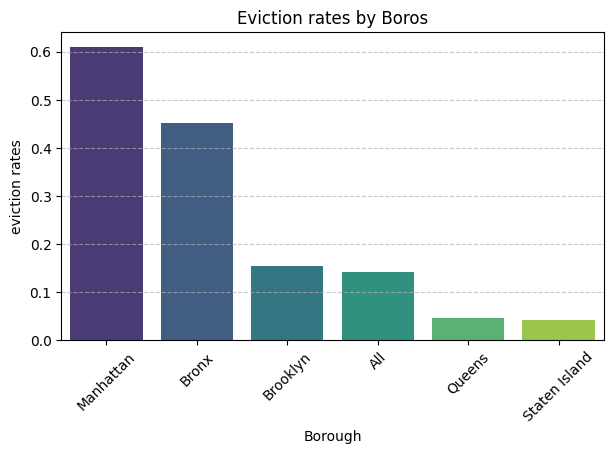

In [74]:
df_sorted = combined_count_evi_df.sort_values('total_eviction_rate', ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_sorted,
    x='borough',
    y='total_eviction_rate',
    palette='viridis'
)
plt.title('Eviction rates by Boros')
plt.xlabel('Borough')
plt.ylabel('eviction rates')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# will probably be better in excel

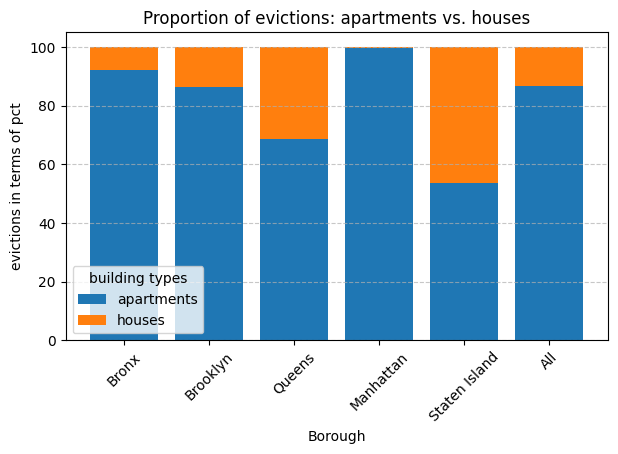

In [75]:
boroughs = combined_count_evi_df['borough']
apt_rates = combined_count_evi_df['evictions_apt_rate']
house_rates = combined_count_evi_df['evictions_house_rate']


plt.figure(figsize=(7, 4))
plt.bar(boroughs, apt_rates, label='apartments', color='#1f77b4')
plt.bar(boroughs, house_rates, bottom=apt_rates, label='houses', color='#ff7f0e')

plt.title('Proportion of evictions: apartments vs. houses')
plt.xlabel('Borough')
plt.ylabel('evictions in terms of pct')
plt.legend(title='building types')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# will probably be better in excel

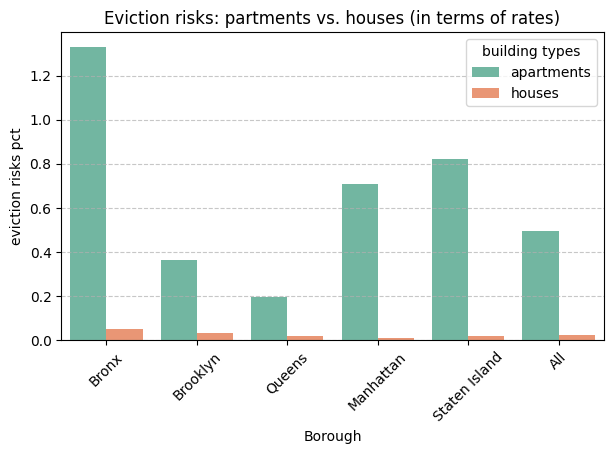

In [76]:
# in terms of eviction percentages (risks)
df_risk = combined_count_evi_df.melt(
    id_vars=['borough'],
    value_vars=['apt_with_eviction_rate', 'house_with_eviction_rate'],
    var_name='type',
    value_name='eviction_risk'
)

df_risk['type'] = df_risk['type'].replace({
    'apt_with_eviction_rate': 'apartments',
    'house_with_eviction_rate': 'houses'
})

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_risk,
    x='borough',
    y='eviction_risk',
    hue='type',
    palette='Set2'
)
plt.title('Eviction risks: partments vs. houses (in terms of rates)')
plt.xlabel('Borough')
plt.ylabel('eviction risks pct')
plt.legend(title='building types')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()